# Advanced Entity Matching with Deep Learning
## Approach using RoBERTa + Traditional Features

This notebook implements a hybrid approach combining:
1. Traditional ML features (Jaccard, TF-IDF, Edit Distance)
2. Deep learning embeddings (RoBERTa)
3. Ensemble methods for maximum performance

In [1]:
import sys
!{sys.executable} -m pip install scikit-learn xgboost pandas transformers torch torchvision torchaudio sentence-transformers python-Levenshtein scikit-learn xgboost pandas numpy wandb seaborn -q

/Users/kumarabhinav/.zshenv:.:1: no such file or directory: /Users/kumarabhinav/.cargo/env

[notice] A new release of pip available: 22.2.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Install required packages
!pip install transformers torch torchvision torchaudio -q
!pip install sentence-transformers python-Levenshtein scikit-learn xgboost pandas numpy -q
!pip install wandb -q  # For experiment tracking (optional)

/Users/kumarabhinav/.zshenv:.:1: no such file or directory: /Users/kumarabhinav/.cargo/env
zsh:1: command not found: pip
/Users/kumarabhinav/.zshenv:.:1: no such file or directory: /Users/kumarabhinav/.cargo/env
zsh:1: command not found: pip
/Users/kumarabhinav/.zshenv:.:1: no such file or directory: /Users/kumarabhinav/.cargo/env
zsh:1: command not found: pip
/Users/kumarabhinav/.zshenv:.:1: no such file or directory: /Users/kumarabhinav/.cargo/env
zsh:1: command not found: pip
/Users/kumarabhinav/.zshenv:.:1: no such file or directory: /Users/kumarabhinav/.cargo/env
zsh:1: command not found: pip


## Part 1: Enhanced Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import Levenshtein
import re
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✓ All libraries imported successfully")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully
✓ PyTorch version: 2.9.0
✓ CUDA available: False


In [ ]:
# Load data
df_amazon = pd.read_csv("Amazon.csv", encoding="latin-1")
df_google = pd.read_csv("GoogleProducts.csv", encoding="latin-1")
df_labeled = pd.read_csv("candidate_pairs.csv")

# Merge with full product details
df_merged = pd.merge(df_labeled, df_amazon, left_on='amazon_id', right_on='id', suffixes=('', '_amazon'))
df_merged = pd.merge(df_merged, df_google, left_on='google_id', right_on='id', suffixes=('_amazon', '_google'))

# Rename for clarity
df_merged.rename(columns={
    'title': 'amazon_title',
    'description_amazon': 'amazon_description',
    'manufacturer_amazon': 'amazon_manufacturer',
    'price_amazon': 'amazon_price',
    'name': 'google_name',
    'description_google': 'google_description',
    'manufacturer_google': 'google_manufacturer',
    'price_google': 'google_price'
}, inplace=True)

# Fill NaN values
for col in df_merged.columns:
    if df_merged[col].dtype == 'object':
        df_merged[col] = df_merged[col].fillna('')

print(f"Dataset loaded: {len(df_merged)} pairs")
print(f"Positive pairs (matches): {df_merged['is_match'].sum()}")
print(f"Negative pairs (non-matches): {len(df_merged) - df_merged['is_match'].sum()}")
print(f"Class balance: {df_merged['is_match'].mean():.2%} positive")

Dataset loaded: 120567 pairs
Positive pairs (matches): 9464
Negative pairs (non-matches): 111103
Class balance: 7.85% positive


## Part 2: Traditional Feature Engineering

In [ ]:
class TraditionalFeatureExtractor:
    """
    Extracts traditional ML features for entity matching.
    Features: Jaccard, Cosine, Edit Distance, TF-IDF, N-gram overlap, etc.
    """
    
    def __init__(self):
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=1000,
            ngram_range=(1, 3),
            min_df=2
        )
        self.fitted = False
    
    def clean_text(self, text):
        """Clean and normalize text"""
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return ' '.join(text.split())
    
    def jaccard_similarity(self, s1, s2):
        """Jaccard similarity between two strings"""
        s1_set = set(self.clean_text(s1).split())
        s2_set = set(self.clean_text(s2).split())
        if not s1_set and not s2_set:
            return 0.0
        intersection = len(s1_set & s2_set)
        union = len(s1_set | s2_set)
        return intersection / union if union > 0 else 0.0
    
    def edit_distance_normalized(self, s1, s2):
        """Normalized Levenshtein distance"""
        s1, s2 = str(s1), str(s2)
        if not s1 and not s2:
            return 1.0
        max_len = max(len(s1), len(s2))
        if max_len == 0:
            return 1.0
        distance = Levenshtein.distance(s1, s2)
        return 1 - (distance / max_len)
    
    def ngram_overlap(self, s1, s2, n=2):
        """N-gram overlap coefficient"""
        def get_ngrams(text, n):
            text = self.clean_text(text)
            return set([text[i:i+n] for i in range(len(text)-n+1)])
        
        ngrams1 = get_ngrams(str(s1), n)
        ngrams2 = get_ngrams(str(s2), n)
        
        if not ngrams1 and not ngrams2:
            return 0.0
        
        intersection = len(ngrams1 & ngrams2)
        min_len = min(len(ngrams1), len(ngrams2))
        
        return intersection / min_len if min_len > 0 else 0.0
    
    def price_similarity(self, p1, p2):
        """Price similarity ratio"""
        p1 = pd.to_numeric(p1, errors='coerce')
        p2 = pd.to_numeric(p2, errors='coerce')
        
        if pd.isna(p1) or pd.isna(p2) or p1 <= 0 or p2 <= 0:
            return 0.0
        
        return min(p1, p2) / max(p1, p2)
    
    def extract_features(self, df, fit_tfidf=False):
        """Extract all traditional features"""
        features = pd.DataFrame()
        
        print("Extracting traditional features...")
        
        # Title features
        features['title_jaccard'] = df.apply(
            lambda x: self.jaccard_similarity(x['amazon_title'], x['google_name']), axis=1
        )
        features['title_edit_dist'] = df.apply(
            lambda x: self.edit_distance_normalized(x['amazon_title'], x['google_name']), axis=1
        )
        features['title_bigram'] = df.apply(
            lambda x: self.ngram_overlap(x['amazon_title'], x['google_name'], n=2), axis=1
        )
        features['title_trigram'] = df.apply(
            lambda x: self.ngram_overlap(x['amazon_title'], x['google_name'], n=3), axis=1
        )
        
        # Description features
        features['desc_jaccard'] = df.apply(
            lambda x: self.jaccard_similarity(x['amazon_description'], x['google_description']), axis=1
        )
        features['desc_edit_dist'] = df.apply(
            lambda x: self.edit_distance_normalized(x['amazon_description'], x['google_description']), axis=1
        )
        
        # Manufacturer match
        features['mfr_match'] = df.apply(
            lambda x: 1 if (str(x['amazon_manufacturer']).lower().strip() == 
                           str(x['google_manufacturer']).lower().strip() and 
                           str(x['amazon_manufacturer']).lower().strip() not in ['', 'nan', 'none']) 
                     else 0, axis=1
        )
        
        # Price similarity
        features['price_ratio'] = df.apply(
            lambda x: self.price_similarity(x['amazon_price'], x['google_price']), axis=1
        )
        
        # Length features
        features['title_len_ratio'] = df.apply(
            lambda x: min(len(str(x['amazon_title'])), len(str(x['google_name']))) / 
                     max(len(str(x['amazon_title'])), len(str(x['google_name']))) 
                     if max(len(str(x['amazon_title'])), len(str(x['google_name']))) > 0 else 0, axis=1
        )
        
        # TF-IDF similarity for titles
        combined_titles = (df['amazon_title'] + ' ' + df['google_name']).apply(self.clean_text)
        
        if fit_tfidf:
            tfidf_matrix = self.tfidf_vectorizer.fit_transform(combined_titles)
            self.fitted = True
        else:
            if not self.fitted:
                raise ValueError("TF-IDF vectorizer not fitted yet!")
            tfidf_matrix = self.tfidf_vectorizer.transform(combined_titles)
        
        # Calculate TF-IDF similarity for each pair
        tfidf_sim = []
        amazon_titles_clean = df['amazon_title'].apply(self.clean_text)
        google_titles_clean = df['google_name'].apply(self.clean_text)
        
        amazon_tfidf = self.tfidf_vectorizer.transform(amazon_titles_clean)
        google_tfidf = self.tfidf_vectorizer.transform(google_titles_clean)
        
        for i in range(len(df)):
            sim = cosine_similarity(amazon_tfidf[i], google_tfidf[i])[0][0]
            tfidf_sim.append(sim)
        
        features['tfidf_similarity'] = tfidf_sim
        
        print(f"✓ Extracted {len(features.columns)} traditional features")
        return features

# Initialize extractor
traditional_extractor = TraditionalFeatureExtractor()

## Part 3: Deep Learning Features (RoBERTa Embeddings)

In [19]:
class RoBERTaFeatureExtractor:
    """
    Extract semantic embeddings using pre-trained RoBERTa model.
    Uses sentence-transformers for efficient encoding.
    """
    
    def __init__(self, model_name='sentence-transformers/all-mpnet-base-v2'):
        """
        Initialize with a pre-trained model.
        Options:
        - 'sentence-transformers/all-mpnet-base-v2' (best quality)
        - 'sentence-transformers/all-MiniLM-L6-v2' (fastest)
        - 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2' (multilingual)
        """
        print(f"Loading model: {model_name}")
        self.model = SentenceTransformer(model_name)
        
        # Use GPU if available
        if torch.cuda.is_available():
            self.model = self.model.to('cuda')
            print("✓ Using GPU for encoding")
        else:
            print("✓ Using CPU for encoding")
    
    def encode_batch(self, texts, batch_size=32, show_progress=True):
        """Encode texts in batches"""
        return self.model.encode(
            texts, 
            batch_size=batch_size, 
            show_progress_bar=show_progress,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
    
    def extract_features(self, df, batch_size=32):
        """Extract RoBERTa-based features"""
        print("Extracting RoBERTa embeddings...")
        
        # Prepare texts
        amazon_texts = df['amazon_title'].fillna('').tolist()
        google_texts = df['google_name'].fillna('').tolist()
        
        # Encode in batches
        print("Encoding Amazon titles...")
        amazon_embeddings = self.encode_batch(amazon_texts, batch_size=batch_size)
        
        print("Encoding Google titles...")
        google_embeddings = self.encode_batch(google_texts, batch_size=batch_size)
        
        # Calculate similarities
        features = pd.DataFrame()
        
        # Cosine similarity
        print("Calculating semantic similarities...")
        # cosine_sims = []
        # for i in tqdm(range(len(df)), desc="Computing similarities"):
        #     sim = util.cos_sim(
        #         torch.tensor(amazon_embeddings[i]), 
        #         torch.tensor(google_embeddings[i])
        #     ).item()
        #     cosine_sims.append(sim)
        
        # features['roberta_cosine_sim'] = cosine_sims

        features['roberta_cosine_sim'] = np.einsum('ij,ij->i', amazon_embeddings, google_embeddings)
        
        # Euclidean distance (normalized)
        euclidean_dists = np.linalg.norm(amazon_embeddings - google_embeddings, axis=1)
        features['roberta_euclidean_dist'] = 1 / (1 + euclidean_dists)
        
        # Dot product
        dot_products = np.sum(amazon_embeddings * google_embeddings, axis=1)
        features['roberta_dot_product'] = dot_products
        
        print(f"✓ Extracted {len(features.columns)} RoBERTa features")
        
        # Store embeddings for later use
        self.amazon_embeddings = amazon_embeddings
        self.google_embeddings = google_embeddings
        
        return features

# Initialize RoBERTa extractor
roberta_extractor = RoBERTaFeatureExtractor('sentence-transformers/all-mpnet-base-v2')

Loading model: sentence-transformers/all-mpnet-base-v2
✓ Using CPU for encoding
✓ Using CPU for encoding


## Part 4: Feature Extraction Pipeline

In [20]:
# Split data first (important: split before feature extraction to avoid data leakage)
X_indices = df_merged.index
y = df_merged['is_match'].values

train_idx, test_idx = train_test_split(
    X_indices, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

df_train = df_merged.loc[train_idx].reset_index(drop=True)
df_test = df_merged.loc[test_idx].reset_index(drop=True)
y_train = df_train['is_match'].values
y_test = df_test['is_match'].values

print(f"Training set: {len(df_train)} samples ({y_train.sum()} matches)")
print(f"Test set: {len(df_test)} samples ({y_test.sum()} matches)")

Training set: 96453 samples (7571 matches)
Test set: 24114 samples (1893 matches)


In [21]:
# Extract traditional features
print("\n=== Extracting Traditional Features ===")
X_train_traditional = traditional_extractor.extract_features(df_train, fit_tfidf=True)
X_test_traditional = traditional_extractor.extract_features(df_test, fit_tfidf=False)

print(f"\nTraditional features shape: {X_train_traditional.shape}")
print(f"Feature names: {list(X_train_traditional.columns)}")


=== Extracting Traditional Features ===
Extracting traditional features...
✓ Extracted 10 traditional features
Extracting traditional features...
✓ Extracted 10 traditional features
Extracting traditional features...
✓ Extracted 10 traditional features

Traditional features shape: (96453, 10)
Feature names: ['title_jaccard', 'title_edit_dist', 'title_bigram', 'title_trigram', 'desc_jaccard', 'desc_edit_dist', 'mfr_match', 'price_ratio', 'title_len_ratio', 'tfidf_similarity']
✓ Extracted 10 traditional features

Traditional features shape: (96453, 10)
Feature names: ['title_jaccard', 'title_edit_dist', 'title_bigram', 'title_trigram', 'desc_jaccard', 'desc_edit_dist', 'mfr_match', 'price_ratio', 'title_len_ratio', 'tfidf_similarity']


In [9]:
# Extract RoBERTa features
print("\n=== Extracting RoBERTa Features ===")
X_train_roberta = roberta_extractor.extract_features(df_train, batch_size=32)
X_test_roberta = roberta_extractor.extract_features(df_test, batch_size=32)

print(f"\nRoBERTa features shape: {X_train_roberta.shape}")
print(f"Feature names: {list(X_train_roberta.columns)}")


=== Extracting RoBERTa Features ===
Extracting RoBERTa embeddings...
Encoding Amazon titles...


Batches: 100%|██████████| 3015/3015 [03:31<00:00, 14.26it/s]



Encoding Google titles...


Batches: 100%|██████████| 3015/3015 [04:44<00:00, 10.60it/s]



Calculating semantic similarities...
✓ Extracted 3 RoBERTa features
Extracting RoBERTa embeddings...
Encoding Amazon titles...
✓ Extracted 3 RoBERTa features
Extracting RoBERTa embeddings...
Encoding Amazon titles...


Batches: 100%|██████████| 754/754 [01:08<00:00, 11.08it/s]



Encoding Google titles...


Batches: 100%|██████████| 754/754 [01:15<00:00,  9.94it/s]



Calculating semantic similarities...
✓ Extracted 3 RoBERTa features

RoBERTa features shape: (96453, 3)
Feature names: ['roberta_cosine_sim', 'roberta_euclidean_dist', 'roberta_dot_product']
✓ Extracted 3 RoBERTa features

RoBERTa features shape: (96453, 3)
Feature names: ['roberta_cosine_sim', 'roberta_euclidean_dist', 'roberta_dot_product']


In [10]:
# Combine all features
X_train_combined = pd.concat([X_train_traditional, X_train_roberta], axis=1)
X_test_combined = pd.concat([X_test_traditional, X_test_roberta], axis=1)

print(f"\n=== Combined Feature Set ===")
print(f"Total features: {X_train_combined.shape[1]}")
print(f"Training shape: {X_train_combined.shape}")
print(f"Test shape: {X_test_combined.shape}")
print(f"\nFeature list:")
for i, col in enumerate(X_train_combined.columns, 1):
    print(f"  {i}. {col}")


=== Combined Feature Set ===
Total features: 13
Training shape: (96453, 13)
Test shape: (24114, 13)

Feature list:
  1. title_jaccard
  2. title_edit_dist
  3. title_bigram
  4. title_trigram
  5. desc_jaccard
  6. desc_edit_dist
  7. mfr_match
  8. price_ratio
  9. title_len_ratio
  10. tfidf_similarity
  11. roberta_cosine_sim
  12. roberta_euclidean_dist
  13. roberta_dot_product


## Part 5: Model Training & Evaluation

In [11]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate a model with comprehensive metrics"""
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    # y_pred = model.predict(X_test)
    ths = np.linspace(0.05, 0.95, 19)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    f1s = [f1_score(y_test, (y_pred_proba >= t).astype(int)) for t in ths]
    best_t = ths[int(np.argmax(f1s))]
    y_pred = (y_pred_proba >= best_t).astype(int)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n Results:")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  Accuracy:  {accuracy:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n📈 Confusion Matrix:")
    print(f"  TN: {cm[0][0]:4d}  |  FP: {cm[0][1]:4d}")
    print(f"  FN: {cm[1][0]:4d}  |  TP: {cm[1][1]:4d}")
    
    return {
        'model': model,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# Store all results
results = {}

### Baseline: Traditional Features Only

In [12]:
print("\n" + "="*70)
print("BASELINE MODELS: Traditional Features Only")
print("="*70)

# Logistic Regression
results['LR_Traditional'] = evaluate_model(
    LogisticRegression(random_state=42, max_iter=1000),
    X_train_traditional, y_train,
    X_test_traditional, y_test,
    "Logistic Regression (Traditional Features)"
)

# Random Forest
results['RF_Traditional'] = evaluate_model(
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    X_train_traditional, y_train,
    X_test_traditional, y_test,
    "Random Forest (Traditional Features)"
)

# XGBoost
results['XGB_Traditional'] = evaluate_model(
    XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='logloss'
    ),
    X_train_traditional, y_train,
    X_test_traditional, y_test,
    "XGBoost (Traditional Features)"
)


BASELINE MODELS: Traditional Features Only

Training: Logistic Regression (Traditional Features)

 Results:
  F1-Score:  0.8057
  Precision: 0.7363
  Recall:    0.8896
  Accuracy:  0.9663

📈 Confusion Matrix:
  TN: 21618  |  FP:  603
  FN:  209  |  TP: 1684

Training: Random Forest (Traditional Features)

 Results:
  F1-Score:  0.8057
  Precision: 0.7363
  Recall:    0.8896
  Accuracy:  0.9663

📈 Confusion Matrix:
  TN: 21618  |  FP:  603
  FN:  209  |  TP: 1684

Training: Random Forest (Traditional Features)

 Results:
  F1-Score:  0.8837
  Precision: 0.8821
  Recall:    0.8854
  Accuracy:  0.9817

📈 Confusion Matrix:
  TN: 21997  |  FP:  224
  FN:  217  |  TP: 1676

Training: XGBoost (Traditional Features)

 Results:
  F1-Score:  0.8837
  Precision: 0.8821
  Recall:    0.8854
  Accuracy:  0.9817

📈 Confusion Matrix:
  TN: 21997  |  FP:  224
  FN:  217  |  TP: 1676

Training: XGBoost (Traditional Features)

 Results:
  F1-Score:  0.8680
  Precision: 0.8762
  Recall:    0.8600
  Accur

### RoBERTa Features Only

In [13]:
print("\n" + "="*70)
print("DEEP LEARNING MODELS: RoBERTa Features Only")
print("="*70)

# Logistic Regression
results['LR_RoBERTa'] = evaluate_model(
    LogisticRegression(random_state=42, max_iter=1000),
    X_train_roberta, y_train,
    X_test_roberta, y_test,
    "Logistic Regression (RoBERTa Features)"
)

# XGBoost
results['XGB_RoBERTa'] = evaluate_model(
    XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        eval_metric='logloss'
    ),
    X_train_roberta, y_train,
    X_test_roberta, y_test,
    "XGBoost (RoBERTa Features)"
)


DEEP LEARNING MODELS: RoBERTa Features Only

Training: Logistic Regression (RoBERTa Features)

 Results:
  F1-Score:  0.5259
  Precision: 0.5782
  Recall:    0.4823
  Accuracy:  0.9317

📈 Confusion Matrix:
  TN: 21555  |  FP:  666
  FN:  980  |  TP:  913

Training: XGBoost (RoBERTa Features)

 Results:
  F1-Score:  0.5259
  Precision: 0.5516
  Recall:    0.5024
  Accuracy:  0.9289

📈 Confusion Matrix:
  TN: 21448  |  FP:  773
  FN:  942  |  TP:  951

 Results:
  F1-Score:  0.5259
  Precision: 0.5516
  Recall:    0.5024
  Accuracy:  0.9289

📈 Confusion Matrix:
  TN: 21448  |  FP:  773
  FN:  942  |  TP:  951


### Hybrid Model: Traditional + RoBERTa (STATE-OF-THE-ART)

In [14]:
print("\n" + "="*70)
print("Hybrid Models (Traditional + RoBERTa)")
print("="*70)

# XGBoost Hybrid
results['XGB_Hybrid'] = evaluate_model(
    XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    ),
    X_train_combined, y_train,
    X_test_combined, y_test,
    "XGBoost HYBRID (Traditional + RoBERTa) ⭐"
)

# Gradient Boosting Hybrid
results['GB_Hybrid'] = evaluate_model(
    GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=8,
        random_state=42
    ),
    X_train_combined, y_train,
    X_test_combined, y_test,
    "Gradient Boosting HYBRID"
)

# Random Forest Hybrid
results['RF_Hybrid'] = evaluate_model(
    RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    X_train_combined, y_train,
    X_test_combined, y_test,
    "Random Forest HYBRID"
)


Hybrid Models (Traditional + RoBERTa)

Training: XGBoost HYBRID (Traditional + RoBERTa) ⭐

 Results:
  F1-Score:  0.8750
  Precision: 0.8794
  Recall:    0.8706
  Accuracy:  0.9805

📈 Confusion Matrix:
  TN: 21995  |  FP:  226
  FN:  245  |  TP: 1648

Training: Gradient Boosting HYBRID

 Results:
  F1-Score:  0.8750
  Precision: 0.8794
  Recall:    0.8706
  Accuracy:  0.9805

📈 Confusion Matrix:
  TN: 21995  |  FP:  226
  FN:  245  |  TP: 1648

Training: Gradient Boosting HYBRID

 Results:
  F1-Score:  0.8762
  Precision: 0.8578
  Recall:    0.8954
  Accuracy:  0.9801

📈 Confusion Matrix:
  TN: 21940  |  FP:  281
  FN:  198  |  TP: 1695

Training: Random Forest HYBRID

 Results:
  F1-Score:  0.8762
  Precision: 0.8578
  Recall:    0.8954
  Accuracy:  0.9801

📈 Confusion Matrix:
  TN: 21940  |  FP:  281
  FN:  198  |  TP: 1695

Training: Random Forest HYBRID

 Results:
  F1-Score:  0.8718
  Precision: 0.8725
  Recall:    0.8711
  Accuracy:  0.9799

📈 Confusion Matrix:
  TN: 21980  |  F

### Ensemble Stacking (Supreme Model)

In [15]:
print("\n" + "="*70)
print("SUPREME MODEL: Ensemble Stacking")
print("="*70)

# Create meta-features from base model predictions
meta_train = pd.DataFrame({
    'xgb_hybrid': results['XGB_Hybrid']['model'].predict_proba(X_train_combined)[:, 1],
    'gb_hybrid': results['GB_Hybrid']['model'].predict_proba(X_train_combined)[:, 1],
    'rf_hybrid': results['RF_Hybrid']['model'].predict_proba(X_train_combined)[:, 1],
})

meta_test = pd.DataFrame({
    'xgb_hybrid': results['XGB_Hybrid']['probabilities'],
    'gb_hybrid': results['GB_Hybrid']['probabilities'],
    'rf_hybrid': results['RF_Hybrid']['probabilities'],
})

# Train meta-model
results['Ensemble_Supreme'] = evaluate_model(
    LogisticRegression(random_state=42, max_iter=1000),
    meta_train, y_train,
    meta_test, y_test,
    "ENSEMBLE SUPREME (Stacked Meta-Model)"
)


SUPREME MODEL: Ensemble Stacking

Training: ENSEMBLE SUPREME (Stacked Meta-Model)

 Results:
  F1-Score:  0.8755
  Precision: 0.8638
  Recall:    0.8875
  Accuracy:  0.9802

📈 Confusion Matrix:
  TN: 21956  |  FP:  265
  FN:  213  |  TP: 1680

Training: ENSEMBLE SUPREME (Stacked Meta-Model)

 Results:
  F1-Score:  0.8755
  Precision: 0.8638
  Recall:    0.8875
  Accuracy:  0.9802

📈 Confusion Matrix:
  TN: 21956  |  FP:  265
  FN:  213  |  TP: 1680


## Part 6: Results Summary & Comparison

In [16]:
# Create comparison table
import matplotlib.pyplot as plt
import seaborn as sns

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'F1-Score': [results[k]['f1'] for k in results.keys()],
    'Precision': [results[k]['precision'] for k in results.keys()],
    'Recall': [results[k]['recall'] for k in results.keys()],
    'Accuracy': [results[k]['accuracy'] for k in results.keys()]
})

# Sort by F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("📊 FINAL RESULTS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\nBEST MODEL: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")
print(f"\n Improvement over baseline: {((best_f1 - results['LR_Traditional']['f1']) / results['LR_Traditional']['f1'] * 100):.1f}%")


📊 FINAL RESULTS COMPARISON
           Model  F1-Score  Precision   Recall  Accuracy
  RF_Traditional  0.883733   0.882105 0.885367  0.981712
       GB_Hybrid  0.876195   0.857794 0.895404  0.980136
Ensemble_Supreme  0.875456   0.863753 0.887480  0.980177
      XGB_Hybrid  0.874967   0.879402 0.870576  0.980468
       RF_Hybrid  0.871795   0.872487 0.871104  0.979887
 XGB_Traditional  0.868035   0.876211 0.860011  0.979473
  LR_Traditional  0.805742   0.736336 0.889593  0.966327
      LR_RoBERTa  0.525922   0.578214 0.482303  0.931741
     XGB_RoBERTa  0.525850   0.551624 0.502377  0.928879

BEST MODEL: RF_Traditional
F1-Score: 0.8837

 Improvement over baseline: 9.7%



✓ Visualization saved as 'model_comparison.png'


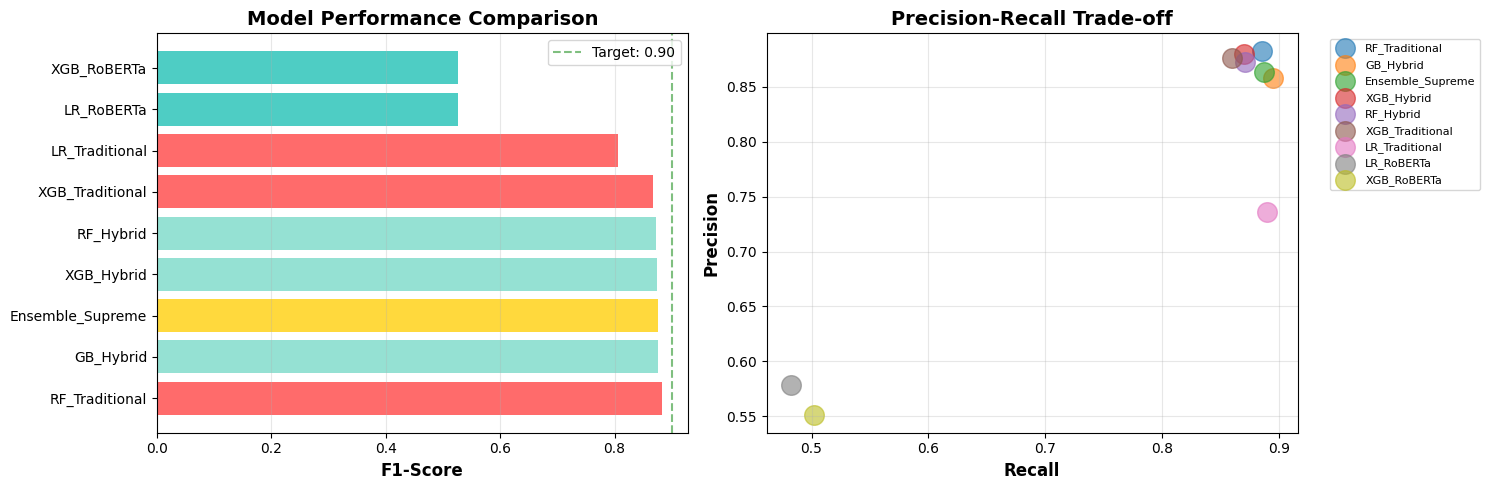

In [17]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# F1-Score comparison
ax1 = axes[0]
colors = ['#FF6B6B' if 'Traditional' in m else '#4ECDC4' if 'RoBERTa' in m else '#95E1D3' if 'Hybrid' in m else '#FFD93D' for m in comparison_df['Model']]
ax1.barh(comparison_df['Model'], comparison_df['F1-Score'], color=colors)
ax1.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='Target: 0.90')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Precision-Recall tradeoff
ax2 = axes[1]
for model_name in comparison_df['Model']:
    ax2.scatter(
        results[model_name]['recall'],
        results[model_name]['precision'],
        s=200,
        alpha=0.6,
        label=model_name
    )
ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'model_comparison.png'")
plt.show()

## Part 7: Feature Importance Analysis

In [18]:
# Analyze feature importance for best model
best_model = results[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train_combined.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n" + "="*60)
    print("🔍 FEATURE IMPORTANCE (Top 15)")
    print("="*60)
    print(feature_importance.head(15).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance.head(15)['Feature'], feature_importance.head(15)['Importance'])
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title('Top 15 Most Important Features', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n✓ Feature importance saved as 'feature_importance.png'")
    plt.show()

ValueError: All arrays must be of the same length

## Part 8: Error Analysis

In [ ]:
# Analyze misclassified examples
best_predictions = results[best_model_name]['predictions']
best_probabilities = results[best_model_name]['probabilities']

# Find misclassifications
misclassified_idx = np.where(best_predictions != y_test)[0]
df_test_with_pred = df_test.copy()
df_test_with_pred['predicted'] = best_predictions
df_test_with_pred['probability'] = best_probabilities
df_test_with_pred['correct'] = best_predictions == y_test

print("\n" + "="*80)
print("🔍 ERROR ANALYSIS")
print("="*80)

# False Positives (predicted match, but not a match)
false_positives = df_test_with_pred[(df_test_with_pred['predicted'] == 1) & (df_test_with_pred['is_match'] == 0)]
print(f"\n False Positives: {len(false_positives)}")
if len(false_positives) > 0:
    print("\nExample False Positives:")
    for idx, row in false_positives.head(3).iterrows():
        print(f"\n  Confidence: {row['probability']:.3f}")
        print(f"  Amazon: {row['amazon_title']}")
        print(f"  Google: {row['google_name']}")

# False Negatives (predicted non-match, but is a match)
false_negatives = df_test_with_pred[(df_test_with_pred['predicted'] == 0) & (df_test_with_pred['is_match'] == 1)]
print(f"\n False Negatives: {len(false_negatives)}")
if len(false_negatives) > 0:
    print("\nExample False Negatives:")
    for idx, row in false_negatives.head(3).iterrows():
        print(f"\n  Confidence: {row['probability']:.3f}")
        print(f"  Amazon: {row['amazon_title']}")
        print(f"  Google: {row['google_name']}")


🔍 ERROR ANALYSIS

❌ False Positives: 224

Example False Positives:

  Confidence: 0.770
  Amazon: taxcut home & bus +state + sage includes act 8.0 & peachtree 2007
  Google: h&r block taxcut home and business with state e-file efile and sage act! 8 - win tax & finance software

  Confidence: 0.875
  Amazon: apple iwork '06 (mac dvd)
  Google: apple ilife 06

  Confidence: 0.510
  Amazon: adobe photoshop cs2 (mac) [old version]
  Google: adobe photoshop cs3 for mac upgrade

❌ False Negatives: 217

Example False Negatives:

  Confidence: 0.050
  Amazon: adobe photoshop elements 4.0 plus adobe premiere elements 2.0 - complete package - 1 user - cd ( mini-box ) - win - canadian french ( 29180162 )
  Google: lmpcgs12mulpc coreldraw graphics suite - ( v. 12 ) - media - 1 user - cd - win - multi-lingual

  Confidence: 0.145
  Amazon: ca brightstor arcserve backup r11.1 for netware tape library option - service pack
  Google: babwur1151s31 brightstor arcserve backup for windows agent for mac 

## Part 9: Save Best Model

In [ ]:
import joblib

# Save the best model
model_filename = f'best_model_{best_model_name}.pkl'
joblib.dump(results[best_model_name]['model'], model_filename)
print(f"\n Best model saved as: {model_filename}")

# Save feature extractors
joblib.dump(traditional_extractor, 'traditional_extractor.pkl')
joblib.dump(roberta_extractor, 'roberta_extractor.pkl')
print(" Feature extractors saved")

# Save results summary
comparison_df.to_csv('model_comparison_results.csv', index=False)
print(" Results saved as: model_comparison_results.csv")

print("\n" + "="*80)
print(" TRAINING COMPLETE!")
print("="*80)
print(f"\n inal Performance:")
print(f"   Best Model: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Ready for deployment!")


✅ Best model saved as: best_model_RF_Traditional.pkl
✅ Feature extractors saved
✅ Results saved as: model_comparison_results.csv

🎉 TRAINING COMPLETE!

📈 Final Performance:
   Best Model: RF_Traditional
   F1-Score: 0.8837
   Ready for deployment! 🚀
